In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
# Load historical stock data
file_path = r'C:\Users\nitin sharma\Downloads\Nitesh Work\Power BI project\RELI10.csv'
data = pd.read_csv(file_path)
print(data.head())

       Date   Open  Close   High    Low  Volume
0  2/1/2024  8.840  9.078  9.690  8.755    8618
1  3/1/2024  9.180  9.469  9.656  9.078    3888
2  4/1/2024  9.316  9.163  9.520  8.670    6876
3  5/1/2024  8.840  9.435  9.520  8.806    1447
4  8/1/2024  9.520  9.367  9.520  8.874    2576


In [3]:
print(data.isnull().sum())

Date      0
Open      0
Close     0
High      0
Low       0
Volume    0
dtype: int64


In [4]:
print(data.shape)

(189, 6)


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 189 entries, 0 to 188
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    189 non-null    object 
 1   Open    189 non-null    float64
 2   Close   189 non-null    float64
 3   High    189 non-null    float64
 4   Low     189 non-null    float64
 5   Volume  189 non-null    int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 9.0+ KB


In [6]:
# Convert 'Date' column to datetime and set as index
data['Date'] = pd.to_datetime(data['Date'], format='%d/%m/%Y')
data.set_index('Date', inplace=True)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 189 entries, 2024-01-02 to 2024-10-01
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    189 non-null    float64
 1   Close   189 non-null    float64
 2   High    189 non-null    float64
 3   Low     189 non-null    float64
 4   Volume  189 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 8.9 KB


In [8]:
# Drop rows with NaN values after creating lag features
data = data.dropna()

In [9]:
print(data.head())

             Open  Close   High    Low  Volume
Date                                          
2024-01-02  8.840  9.078  9.690  8.755    8618
2024-01-03  9.180  9.469  9.656  9.078    3888
2024-01-04  9.316  9.163  9.520  8.670    6876
2024-01-05  8.840  9.435  9.520  8.806    1447
2024-01-08  9.520  9.367  9.520  8.874    2576


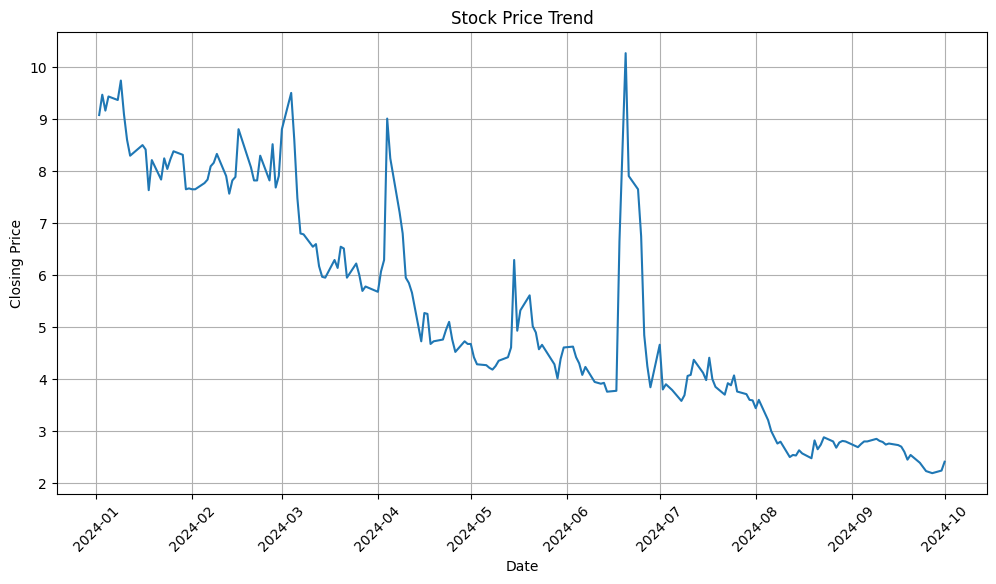

In [10]:

# Plot the 'Close' price over time
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Close'])

# Customize the plot
plt.title('Stock Price Trend')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.grid(True)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

plt.show()

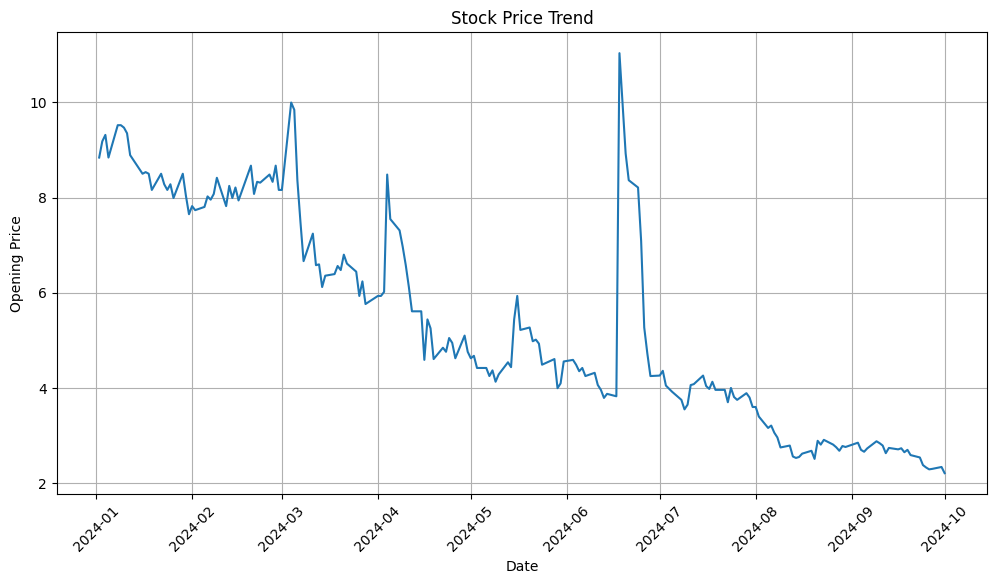

In [11]:
# Plot the 'Open' price over time
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Open'], label='Opening Price')  # Specify label for legend

# Customize the plot
plt.title('Stock Price Trend')
plt.xlabel('Date')
plt.ylabel('Opening Price')
plt.grid(True)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

plt.show()

            Open     Close    Volume
Open    1.000000  0.978792  0.200058
Close   0.978792  1.000000  0.093978
Volume  0.200058  0.093978  1.000000


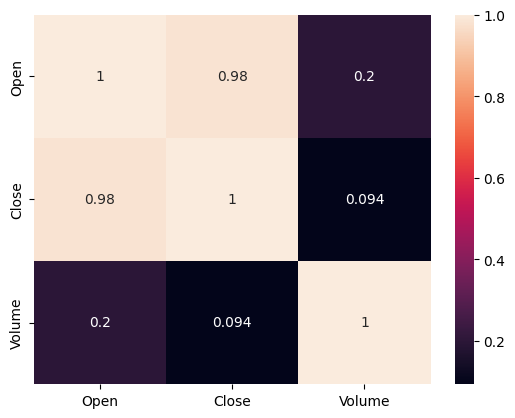

In [12]:
# Calculate correlation matrix
correlation_matrix = data[['Open', 'Close', 'Volume']].corr()
print(correlation_matrix)

# Visualize correlation matrix
sns.heatmap(correlation_matrix, annot=True)
plt.show()

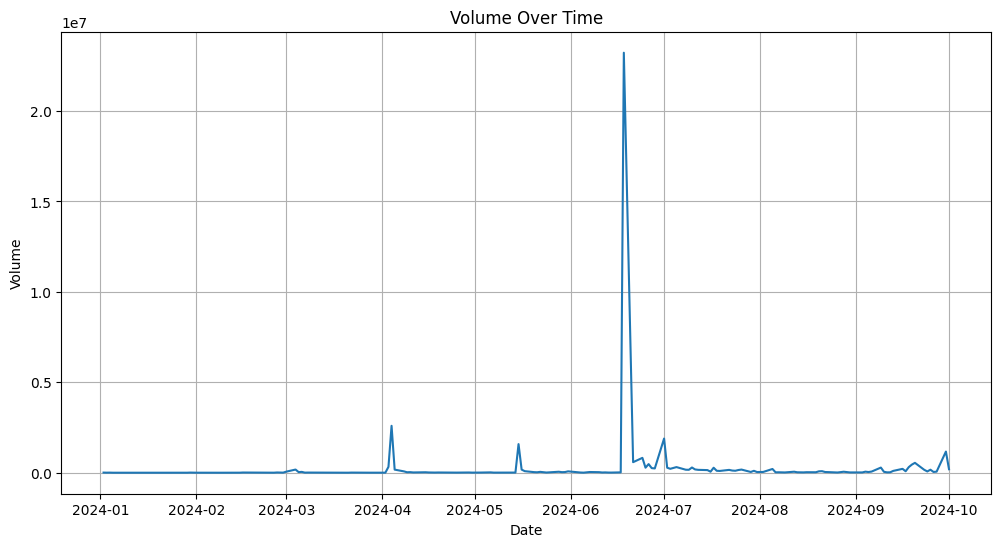

In [13]:
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Volume'])
plt.xlabel('Date')
plt.ylabel('Volume')
plt.title('Volume Over Time')
plt.grid(True)
plt.show()

In [14]:
# Create lag features
lags = 10  # Increased lag length for better capturing price movement
for lag in range(1, lags + 1):
    data[f'Open_lag_{lag}'] = data['Open'].shift(lag)
    data[f'Close_lag_{lag}'] = data['Close'].shift(lag)

In [15]:
# Add moving averages and volatility
data['Open_MA_5'] = data['Open'].rolling(window=5).mean()
data['Close_MA_5'] = data['Close'].rolling(window=5).mean()
data['Open_MA_10'] = data['Open'].rolling(window=10).mean()
data['Close_MA_10'] = data['Close'].rolling(window=10).mean()

data['Open_volatility'] = data['Open'].rolling(window=5).std()
data['Close_volatility'] = data['Close'].rolling(window=5).std()

In [16]:
print(data.head())

             Open  Close   High    Low  Volume  Open_lag_1  Close_lag_1  \
Date                                                                      
2024-01-02  8.840  9.078  9.690  8.755    8618         NaN          NaN   
2024-01-03  9.180  9.469  9.656  9.078    3888       8.840        9.078   
2024-01-04  9.316  9.163  9.520  8.670    6876       9.180        9.469   
2024-01-05  8.840  9.435  9.520  8.806    1447       9.316        9.163   
2024-01-08  9.520  9.367  9.520  8.874    2576       8.840        9.435   

            Open_lag_2  Close_lag_2  Open_lag_3  ...  Open_lag_9  Close_lag_9  \
Date                                             ...                            
2024-01-02         NaN          NaN         NaN  ...         NaN          NaN   
2024-01-03         NaN          NaN         NaN  ...         NaN          NaN   
2024-01-04       8.840        9.078         NaN  ...         NaN          NaN   
2024-01-05       9.180        9.469        8.84  ...         NaN     

In [17]:
print(data.tail())

            Open  Close   High   Low   Volume  Open_lag_1  Close_lag_1  \
Date                                                                     
2024-09-25  2.33   2.23  2.399  2.21   168000        2.38         2.31   
2024-09-26  2.29   2.21  2.330  2.21    43800        2.33         2.23   
2024-09-27  2.30   2.19  2.300  2.15    60900        2.29         2.21   
2024-09-30  2.34   2.24  2.570  2.23  1170500        2.30         2.19   
2024-10-01  2.21   2.41  2.410  2.17   195200        2.34         2.24   

            Open_lag_2  Close_lag_2  Open_lag_3  ...  Open_lag_9  Close_lag_9  \
Date                                             ...                            
2024-09-25        2.54         2.39        2.59  ...       2.630         2.74   
2024-09-26        2.38         2.31        2.54  ...       2.740         2.76   
2024-09-27        2.33         2.23        2.38  ...       2.710         2.73   
2024-09-30        2.29         2.21        2.33  ...       2.733         2.7

In [18]:
# Features and target for Open and Close price prediction
features = [col for col in data.columns if 'lag' in col or 'MA' in col or 'volatility' in col]

In [19]:
# Split the data into training and test sets for Open price
X_open = data[features]
y_open = data['Open']
X_train_open, X_test_open, y_train_open, y_test_open = train_test_split(X_open, y_open, test_size=0.2, random_state=42)

In [20]:
# Split the data for Close price
X_close = data[features]
y_close = data['Close']
X_train_close, X_test_close, y_train_close, y_test_close = train_test_split(X_close, y_close, test_size=0.2, random_state=42)

In [21]:
# Train the XGBoost models
model_open = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
model_close = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

model_open.fit(X_train_open, y_train_open)
model_close.fit(X_train_close, y_train_close)

# Predict the next 5 days' Open and Close prices
last_row = data.iloc[-1].copy()
predictions_open = []
predictions_close = []

for _ in range(5):
    # Prepare input features for the prediction
    input_features = np.array(
        [last_row[f'Open_lag_{i}'] for i in range(1, lags + 1)] +
        [last_row[f'Close_lag_{i}'] for i in range(1, lags + 1)] +
        [last_row[f'Open_MA_5'], last_row[f'Close_MA_5'],
         last_row[f'Open_MA_10'], last_row[f'Close_MA_10'],
         last_row[f'Open_volatility'], last_row[f'Close_volatility']]
    ).reshape(1, -1)

    # Predict next Open and Close prices
    next_open = model_open.predict(input_features)[0]
    next_close = model_close.predict(input_features)[0]

    predictions_open.append(next_open)
    predictions_close.append(next_close)

    # Update last_row for the next prediction
    for lag in range(lags, 1, -1):
        last_row[f'Open_lag_{lag}'] = last_row[f'Open_lag_{lag - 1}']
        last_row[f'Close_lag_{lag}'] = last_row[f'Close_lag_{lag - 1}']
    last_row['Open_lag_1'] = next_open
    last_row['Close_lag_1'] = next_close

In [22]:
# Generate dates for predictions starting the day after the last date in the dataset
start_date = data.index[-1] + pd.Timedelta(days=1)
dates = pd.date_range(start=start_date, periods=5, freq='D')

# Predict on the test set for Open and Close prices
y_pred_open = model_open.predict(X_test_open)
y_pred_close = model_close.predict(X_test_close)

In [23]:
# Calculate evaluation metrics for Open prices
mse_open = mean_squared_error(y_test_open, y_pred_open)
mae_open = mean_absolute_error(y_test_open, y_pred_open)
r2_open = r2_score(y_test_open, y_pred_open)

# Calculate evaluation metrics for Close prices
mse_close = mean_squared_error(y_test_close, y_pred_close)
mae_close = mean_absolute_error(y_test_close, y_pred_close)
r2_close = r2_score(y_test_close, y_pred_close)

# Print the metrics for Open prices
print("Open Price Metrics:")
print(f"Mean Squared Error: {mse_open:.2f}")
print(f"Mean Absolute Error: {mae_open:.2f}")
print(f"R2 Score: {r2_open:.2f}")

# Print the metrics for Close prices
print("\nClose Price Metrics:")
print(f"Mean Squared Error: {mse_close:.2f}")
print(f"Mean Absolute Error: {mae_close:.2f}")
print(f"R2 Score: {r2_close:.2f}")

Open Price Metrics:
Mean Squared Error: 0.20
Mean Absolute Error: 0.25
R2 Score: 0.96

Close Price Metrics:
Mean Squared Error: 0.24
Mean Absolute Error: 0.35
R2 Score: 0.95


In [24]:
# Display predictions in text format
for date, open_price, close_price in zip(dates, predictions_open, predictions_close):
    print(f"Date: {date.date()}, Predicted Open: {open_price:.2f}, Predicted Close: {close_price:.2f}")

Date: 2024-10-02, Predicted Open: 2.34, Predicted Close: 2.41
Date: 2024-10-03, Predicted Open: 2.34, Predicted Close: 2.40
Date: 2024-10-04, Predicted Open: 2.33, Predicted Close: 2.37
Date: 2024-10-05, Predicted Open: 2.33, Predicted Close: 2.31
Date: 2024-10-06, Predicted Open: 2.33, Predicted Close: 2.31


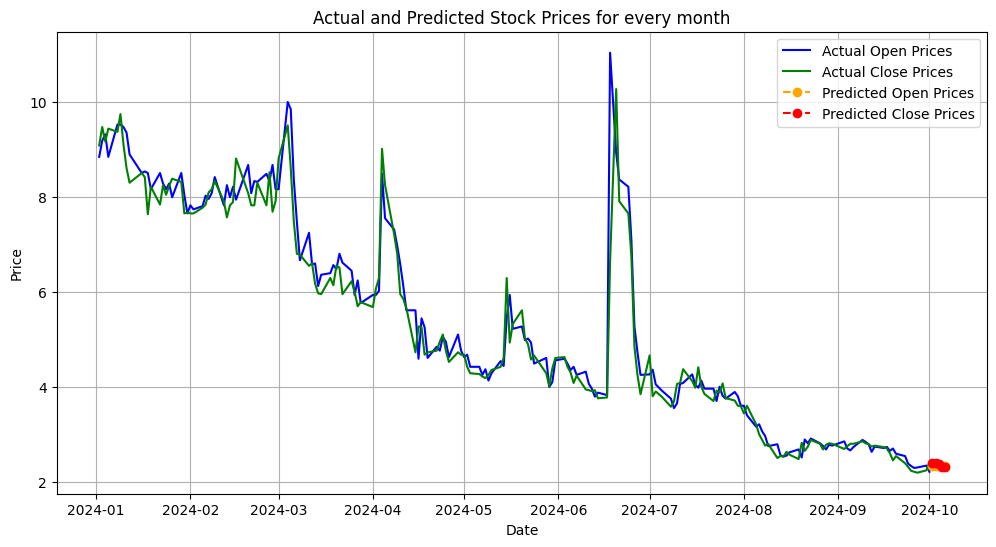

In [26]:
# Visualize actual and predicted values
plt.figure(figsize=(12, 6))

# Plot actual and predicted prices
plt.plot(data.index, data['Open'], label='Actual Open Prices', color='blue')
plt.plot(data.index, data['Close'], label='Actual Close Prices', color='green')
plt.plot(dates, predictions_open, label='Predicted Open Prices', marker='o', linestyle='--', color='orange')
plt.plot(dates, predictions_close, label='Predicted Close Prices', marker='o', linestyle='--', color='red')

plt.title('Actual and Predicted Stock Prices for every month')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()


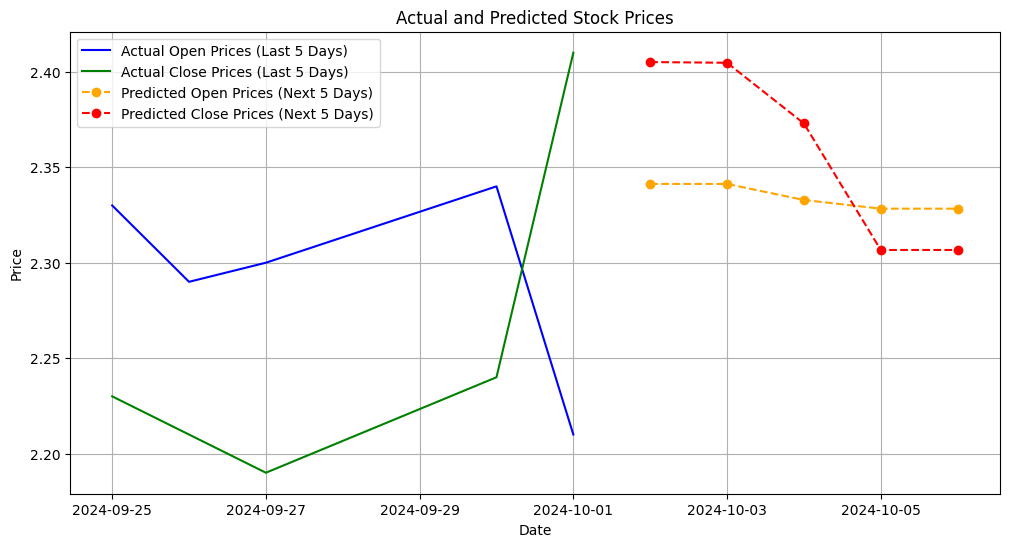

In [25]:
# Visualize actual and predicted values
plt.figure(figsize=(12, 6))

# Plot actual prices for the last 5 days and predicted prices for the next 5 days
plt.plot(data.index[-5:], data['Open'][-5:], label='Actual Open Prices (Last 5 Days)', color='blue')
plt.plot(data.index[-5:], data['Close'][-5:], label='Actual Close Prices (Last 5 Days)', color='green')
plt.plot(dates, predictions_open, label='Predicted Open Prices (Next 5 Days)', marker='o', linestyle='--', color='orange')
plt.plot(dates, predictions_close, label='Predicted Close Prices (Next 5 Days)', marker='o', linestyle='--', color='red')

plt.title('Actual and Predicted Stock Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()

In [28]:
# Set the option to suppress the warning
pd.set_option('future.no_silent_downcasting', True)

# Forward fill to fill missing data if necessary
combined_data.ffill(inplace=True)

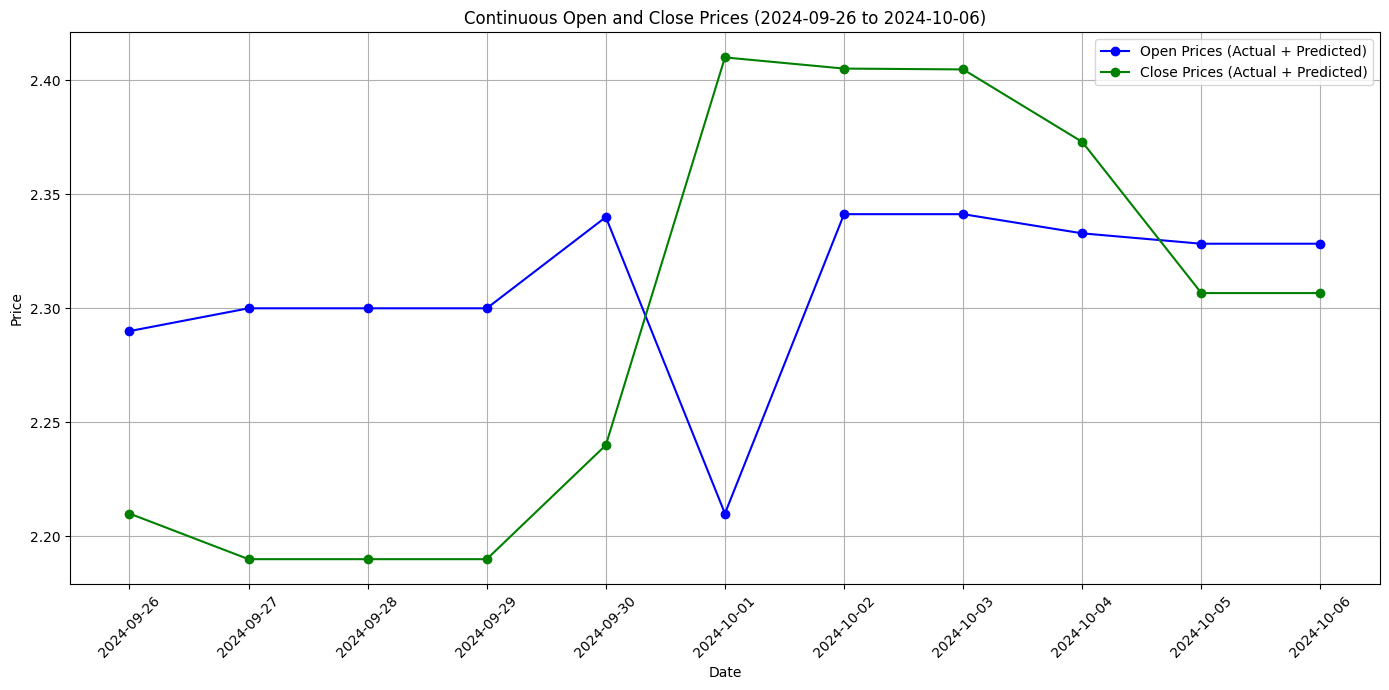

In [32]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'data' is your original DataFrame with a datetime index
# Get the most recent date in the data
end_date = data.index.max()

# Calculate the start date as 5 days before the end date (for actual data)
start_date = end_date - pd.Timedelta(days=5)

# Create a DataFrame for the combined data (actual + predicted)
all_dates = pd.date_range(start=start_date, end=end_date + pd.Timedelta(days=5), freq='D')
combined_data = pd.DataFrame(index=all_dates, columns=['Open', 'Close'])

# Fill the DataFrame with actual values for the last 5 days
for date in data.index:
    if start_date <= date <= end_date:
        combined_data.loc[date, 'Open'] = data.loc[date, 'Open']
        combined_data.loc[date, 'Close'] = data.loc[date, 'Close']

# Fill the DataFrame with predicted values for the next 5 days
for date, open_price, close_price in zip(dates, predictions_open, predictions_close):
    # Predicted days should be after the last actual day in the dataset
    if end_date < date <= end_date + pd.Timedelta(days=5):
        combined_data.loc[date, 'Open'] = open_price
        combined_data.loc[date, 'Close'] = close_price

# Ensure no missing values for Open and Close using forward fill if necessary
combined_data.ffill(inplace=True)  # Forward fill to fill missing data if necessary
combined_data.infer_objects()  # Ensure proper dtype conversion
combined_data.sort_index(inplace=True)

# Plot the graph
plt.figure(figsize=(14, 7))

# Plot Open prices as a continuous line
plt.plot(combined_data.index, combined_data['Open'], label='Open Prices (Actual + Predicted)', color='blue', marker='o')

# Plot Close prices as a continuous line
plt.plot(combined_data.index, combined_data['Close'], label='Close Prices (Actual + Predicted)', color='green', marker='o')

# Add graph details
plt.title(f'Continuous Open and Close Prices ({start_date.date()} to {(end_date + pd.Timedelta(days=5)).date()})')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.xticks(ticks=combined_data.index, labels=[date.strftime('%Y-%m-%d') for date in combined_data.index])  # Ensure 10 dates on x-axis
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()
